# Synopsis
Dans cet atelier nous mettons en pratique les concepts vus ce mardi. Pour cela,
nous analysons une base de données publique fournissant une estimation des
émissions de carbone chaque année (sur base de la consommation de carburants
fossiles et de la production de ciment) entre 1751 et 2014 [1].

Les données sont fournies sous forme de deux listes `X` et `Y`. La liste `X`
contient les années de mesures alors que la liste `Y` contient les émissions de
carbone, exprimées en millions de tonnes. L'entrée en position `i` de la liste
`X` correspond à l'année des émissions de carbone à la position `i` de la liste
`Y`. Par exemple si `X[i] = 2000` et `Y[i] = 6733`, cela signifie que 6733
millions de tonnes de carbone ont été émises en l'an 2000.

La liste `X` est ordonnée en ordre strictement croissant telle que pour tout
`i >= 0`,
* si `j > i` et `j < len(X)` alors `X[j] > X[i]`
* si `j = i` et `j < len(X)` alors `X[j] = X[i]`.

La combinaison de `X` et `Y` forme ce qu'on appelle couramment une _série
temporelle_ [2].

Nous commencerons par afficher les données sous forme de graphique et à y
apporter quelques interprétations. Ensuite, nous modéliserons la tendance de
cette série temporelle par une fonction de croissance exponentielle et
utiliserons ce modèle pour fournir une analyse circonstanciée de l'évolution des
émissions de carbone ces derniers siècles. Finalement, nous proposerons une
ébauche de validation de notre modèle et en nuancerons les conclusions.

# CREDIT
Cet atelier est basé sur les cours "Cours enjeux environnementaux Bilan carbone"
de Sylvain Chevillard [3], chargé de recherche à l'Inria.

# Chargement des données
Utilisons la fonction `loadData` pour charger la base de données en mémoire et
accéder à ces information via les listes `X` et `Y`. Cette fonction est définie
dans `tools.py` que nous devont donc importer en premier lieu. N'hésitez pas à
regarder les fichiers `tools.py` et `global.1751_2014.csv` pour comprendre
comment il est possible de stocker des informations et de les extraire de
manière systématique.

Pour rendre notre code plus générique utilisons une constante contenant le nom
du ficher contenant les données brutes.

In [1]:
from tools import *

In [2]:
FICHIER_DONNEES_BRUTES = 'global.1751_2014.csv' # ficher de données à charger
X, Y = loadData(FICHIER_DONNEES_BRUTES)         # charger les données en mémoire

# Analyse des données

## Représentation graphique

Les données qui composent notre série temporelle étant chargées en mémoire nous
pouvons les visualiser grâce à un graphe. Même si les données dont nous
disposons sont fondamentalement discrètes, il est d'usage de représenter les 
séries temporelles avec une ligne continue passant par tous les couples
_(temps, valeur)_ issus de la base de données.

Nous allons utiliser la librairie `matplotlib` de Python [4]. Cette librairie
permet de représenter de manière graphique des jeu de données arbitraires. Plus
précisément nous allons utiliser la fonction `pyplot` de cette librairie [5].
Pour nous simplifier la tâche, nous l'avons déjà importée et pouvons l'appeler
n'importe où dans le code avec nom `plt`.

Voici 4 fonctions de `pyplot` qui vont nous servir pour représenter nos données
de manière graphique:
* `plt.pot(x, y, label)` qui trace la courbe où `x` est une liste de point en
abscisse et `y` est la liste de points en ordonnées correspondant aux abscisse.
`label` est le nom de la courbe.

* `plt.xlabel(texte)` permet d'indiquer le nom de l'axe des abscisse.
* `plt.ylabel(texte)` permet d'indiquer le nom de l'axe des ordonnées.
* `plt.legend()` demande d'afficher la légende.

L'exemple ci-dessous, montre comment utiliser la fonction `plt` pour tracer une
courbe.

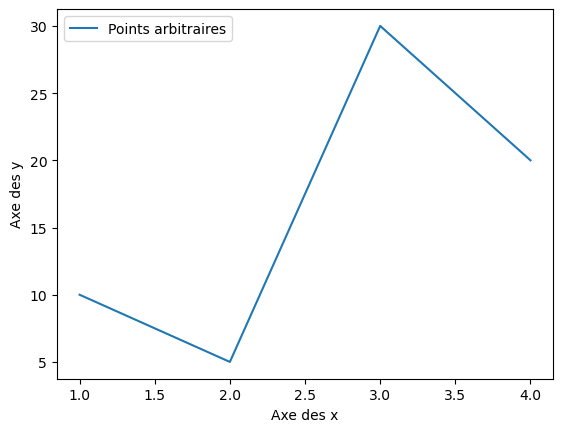

In [3]:
abscisse = [1,2,3,4]
ordonnees = [10,5, 30, 20]
plt.plot(abscisse, ordonnees, label='Points arbitraires')
plt.xlabel('Axe des x')
plt.ylabel('Axe des y')
plt.legend()

Utilisons la fonction `plt` pour représenter de manière graphique nos données `X`
et `Y`. L'axe des abscisses devrait être nommé `Années` alors que l'axe des
ordonnées devrait être nommé `Émissions fossiles en MtC`. `MtC` signifiant
millions de tonnes d'émissions de carbone ici. La courbe devrait avoir pour
légende `Données empiriques`.

> **Pourquoi lorsque nous représentons des données il est indispensable de toujours
> nommer ces données et leurs axes ainsi que de préciser dans quelles unités les
> données sont exprimées?**

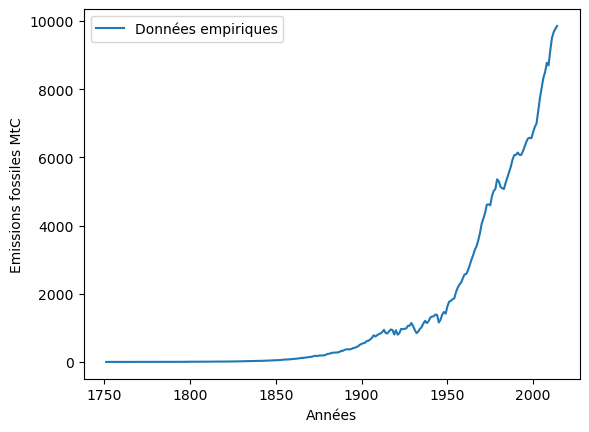

In [4]:
plt.plot(X, Y, label='Données empiriques')  # tracer la courbe
plt.xlabel('Années')                        # nommer l'axe des x
plt.ylabel('Émissions fossiles MtC')        # nommer l'axe des y
plt.legend()                                # afficher la légende

> **Commentez la courbe obtenue en la plaçant dans le contexte historique.**

> **Quelle a été la quantité totale d'émissions fossiles durant la période
> couverte par le jeu de données? Commentez cette valeur.**

In [5]:
debut = X[0]                # date de première mesure
fin = X[len(X)-1]           # date de dernière mesure
total = sum(Y)              # total des émissions

# afficher le total
print ("L'humanité a émis {total} MtC entre {debut} et {fin}."
        .format(debut=debut, fin=fin, total=total) ) 


L'humanité a émis 402068 MtC entre 1751 et 2014.


## Modélisation

Il est possible de modéliser la tendance globale de la série temporelle de notre
jeu de données avec une croissance exponentielle. Ce modèle est caractérisé par
deux paramètres:
* un facteur de croissance et
* une valeur initiale.

Et peut s'écrire selon la relation de récurrence suivante :
* _y(n+1) = C \* y(n)_,

ou, ce qui revient au même, l'expression suivante en fonction de _n_ :

* _y(n) = C^n \* y(0)_

où _y(n)_ est la valeur de _y_ à l'itération _n_ pour tout _n_ entier et
_n >= 0_ et _C_ est le facteur de croissance annuelle.

Dans notre contexte une itération correspond à une année. Par exemple si la
valeur initiale _y(0)_ est obtenue pour l'année 2000 alors _y(3)_ est la valeur
correspondant à l'année 2003.

Pour simplifier notre raisonnement nous allons appliquer un principe
fondamental de la programation: _la décomposition en sous-problèmes_.
Définissons donc la fonction `modeleExponentiel(croissance, y0, n)` où
`croissance` est la taux de croissance annuel, exprimé en pourcents, `y0` est
la valeur initiale et `n` est l'itération pour laquelle on souhaite calculer la
valeur.

__Note 1 :__ un taux de croissance annuel de _10%_ correspond à un facteur de
croissance de `1.1`.

__Note 2 :__ un nombre _x_ est élevé à la puissance _n_ en utilisant la syntaxe
`x**n` en python. Par exemple l'expression
`'2 à la puissance 3 vaut {}'.format(2**3)` en python donne la chaîne de
caractères `'2 à la puissance 3 vaut 8'`.

In [6]:
def modeleExponentiel(croissance, y0, n):
    """
    Parameters
    ----------
    croissance: float
        taux de croissance annuel exprimé en %
    y0: float
        valeur initiale
    n: int
        itération à laquelle prévoir la valeur

    Returns
    -------
    float
        la valeur de l'exponentielle au bout de n itérations
    """
    C = 1.0 + (croissance / 100.0)  # facteur de croissance sur base du taux de
                                    # croissance annuel

    yn = (C ** n) * y0              # valeur au bout de n années

    return yn                       # retourner la valeur après n années

Pour utiliser ce modèle il est nécessaire de connaître la valeur initiale et le
facteur de croissance. Pour cela nous définissions la fonction
`parametresModeleExponentiel(X, Y)` qui calcule ces deux paramètre pour le jeu
de données défini par `X` et `Y`.

> **Trouvez une stratégie pour calculer ces paramètres sur la série temporelle
> définie par le jeu de données. Une possibilité serait de considérer le premier
> point de la série et le dernier point de cette série, mais d'autres stratégies
> sont possibles.**

__Note 1 :__ il est utile de se souvenir que la racine _n_ ième d'un nombre peut
ce calculer en portant ce nombre à la puissance _1/n_.

In [7]:
def parametresModeleExponentiel(X, Y):
    """
    Parameters
    ----------
    X: list
        abscisses
    Y: list
        ordonnées
    
    Returns
    -------
    y0: float
        la valeur initiale de l'exponentielle
    croissance: float
        le taux de croissance exprimé en pourcents
    """
    x0 = X[0]                       # première année de mesures
    y0 = Y[0]                       # valeur des émissions lors de cette année

    xn = X[len(X) - 1]              # dernière année de mesures
    yn = Y[len(X) - 1]              # valeur des émissions lors de cette année

    nb_annees = xn - x0             # nombre d'années de mesures (i.e., nombre
                                    # d'itérations)

    C = (yn / y0)**(1.0/nb_annees)  # facteur de croissance
    
    croissance = (C - 1.0) * 100.0    # taux de croissance annuel en %

    return y0, croissance           # retourner la valeur initiale et le taux

> **Justifiez votre stratégie de calcul des paramètres du modèle exponentiel.**

En jargon ces stratégies s'appellent des _ajustement de courbes_
(_curve fitting_). En effet, l'idée sous-jacente est de trouver les paramètres
du modèle tels que la courbe qui sera calculée par le modèle ressemble le
plus possible aux données qui ont servi à construire le modèle.

Lorsque l'on travaille avec des bases de données, il est souvent intéressant de
se concentrer sur un sous-ensemble de ces données.

Pour la suite de notre analyse, nous allons limiter notre étude à certaines
périodes de temps. En vertu du principe de décomposition en
sous-problèmes créons la fonction `donneesPeriode(X, Y, debut, fin)`. `X` et `Y`
sont les valeurs en x et y des données brutes. `debut` est la date de début
souhaitée de la période à extraire des données brutes et `fin` est la date de
fin de cette période. La fonction retourne `X_` et `Y_` deux sous-listes
extraites de `X` et `Y`. Notre hypothèse de travail ici est que les données
brutes contiennent toutes les années, classées de manière croissante.

Si `X = [2001, 2002, 2003, 2004]` et `Y = [1, 5, 3, 6]` alors `X_` et `Y_`
obtenus par l'appel `X_, Y_ = donneesPeriode(X, Y, 2002, 2003)`  devraient
valoir `[2002, 2003]` et `[5, 3]`, respectivement.

Python offre une syntaxe simple pour extraire une sous-liste d'une liste
simplement en donnant l'index du début de la sous-liste et son index de fin,
séparés par le symbole `:`. Ainsi l'expression `liste[i:j]` retourne la
sous-liste constituée des éléments de la liste `liste`, commençant à l'index `i`
inclu et terminant à l'indice `j` exclu. Python, comme la majorité des langages
de programmation, indexe ses listes en partant de 0. Dans l'exemple ci-dessus,
`X[0]` donnerait donc la valeur 2001 alors que `X[2]` donnerait `2003`.

Pour extraire la sous-liste commençant à l'année 2002 et terminant à l'année
2003 il nous suffit donc de faire `X_ = X[1:3]` et `Y_ = Y[1:3]` car l'année
2002 se trouve à l'index 1 et l'année 2003 se trouve à l'index 2 de `X`.

La difficulté réside donc ici à trouver les index de début et de fin de la
sous-liste qui nous intéresse.

In [8]:
def donneesPeriode(X, Y, debut, fin):
    """
    Parameters
    ----------
    X: list
        abscisses
    Y: list
        ordonnées
    debut: int
        date de début des données à extraire
    fin: int
        date de fin des données à extraire
    
    Returns
    -------
    X_: list
        sous-ensemble des abscisses sur l'intervalle de temps
    Y_: list
        sous-ensemble des ordonnées sur l'intervalle de temps
    """
    nb_mesures = fin - debut + 1                # nombre de mesures à extraire

    index_initial = debut - X[0]                # index de la première mesure
    index_final = index_initial + nb_mesures    # index de la dernière mesure

    X_ = X[index_initial:index_final]           # garder les x sur l'intervalle 
    Y_ = Y[index_initial:index_final]           # garder les y sur l'intervalle

    return X_, Y_                               # retourner les x et les y

Il ne nous reste plus maintenant qu'à définir une fonction qui génère tous les
points sur une période de temps pour le modèle exponentiel. Pour cela
définissons la fonction  `parametresModeleExponentielPeriode(X, Y, debut, fin)`
où `X` et `Y` sont les données brutes issues de la base de données et `debut` et
`fin` sont les années sur lesquelles nous souhaitons restreindre l'étude. Cette
fonctions retourne `X_` et `Y_` qui sont les données brutes sur l'intervalle de
temps _[debut, fin]_ mais elle retourne aussi `Y_modele` qui est l'ensemble des
ordonnées telles que calculées par le modèle et `croissance` qui est le taux de
croissance annuel exprimé en pourcent tel qu'estimé par l'ajustement de courbe.

La fonction `parametresModeleExponentielPeriode` consiste donc en l'assemblage
de la fonction `donneesPeriode`, de la fonction `parametresModeleExponentiel`
et de la fonction `modeleExponentiel`.

In [9]:
def parametresModeleExponentielPeriode(X, Y, debut, fin):
    """
    Parameters
    ----------
    X: list
        abscisses
    Y: list
        ordonnées
    debut: int
        date de début des données à extraire
    fin: int
        date de fin des données à extraire
    
    Returns
    -------
    X_: list
        sous-ensemble des abscisses sur l'intervalle de temps
    Y_: list
        sous-ensemble des ordonnées sur l'intervalle de temps
    Y_modele: list
        ordonnées calculées par le modèle sur l'intervalle de temps
    croissance: float
        le taux de croissance estimé par l'ajustement de courbe, exprimé en
        pourcents
    """
    X_, Y_ = donneesPeriode(X, Y, debut, fin)   # données sur l'intervalle

    # obtenir les parametres de l'exponentielle
    y0, croissance = parametresModeleExponentiel (X_, Y_) 

    # calculer toutes les émissions dans l'intervalle de temps grace au modèle
    # exponentiel
    Y_modele = [modeleExponentiel(croissance, y0, i) for i in range(len(X_))]
    
    return X_, Y_, Y_modele, croissance # retourner les données calculées

## Exploitation des modèles

Nous disposons maintenant de toutes les fonctions nécessaires pour analyser
notre jeu de données.

Commençons par étudier le taux de croissance sur différentes périodes de temps 
en utilisant un ajustement de courbes pour déterminer les paramètres du modèle
de croissance exponentielle.

Plus précisément, étudions les trois périodes suivantes:
* l'entièreté des données
* la période [1850, 1913]
* la période [1945, 1973]


> **Quels taux de croissance obtenez-vous pour chacune de ces périodes?
> Pouvez-vous expliquer les différences?**

> **Représentez graphiquement vos résultats**

Comme calculer les paramètres d'un modèle peut s'avérer lent et gourmand en
ressources, et donc en énergie, nous sauvegarderons nos résultats en mémoire.
La structure de donnée _dictionnaire_ est toute indiquée pour accomplir ce
travail [6]. Un dictionnaire associe une _valeur_ à une _clé_. Dans notre cas,
la clé est la période et la valeur le taux de croissance annuel exprimé en
pourcents. Pour obtenir la valeur d'une clé il suffit d'utiliser l'expression
`dictionnaire[cle]`. Pour associer une valeur à une clé l'instruction
`dictionnaire[cle] = valeur` est utilisée.

Par exemple pour créer le dictionnaire `croissance` et lui ajouter la période
_[2000, 2002]_ qui a pour valeur 42, nous exécuterons le code suivant:
```python
croissance = dict()
croissance[(2000, 2002)] = 42
```

et l'expression `'la valeur associée à la période [2000,2002]
est {}'.format(croissance[(2000, 2002)])` donne la chaîne de caractère
`la valeur associée à la période [2000,2002] est 42'`.

Commençons par lister toutes les périodes de temps qui nous intéressent et
sauvegardons cette information dans une liste appelée `periodes`.

In [10]:
periodes = [
    (X[0], X[len(X)-1]),                    # l'entiereté des données
    (1850, 1913),                           # [1850, 1913]
    (1945, 1973),                           # [1945, 1973]
    (1900, 2014)                            # [1900, 2014]
    ]                                       # lister les intervalles à étudier

Créons le dictionnaire `croissances` qui stockera le taux de croissance annuel,
exprimé en pourcents, calculé par le modèle exponentiel pour toutes les
périodes.

Créons aussi le dictionnaire `modeles` qui stockera les ordonnées calculées par
le modèle exponentiel pour toutes les périodes.

In [11]:
croissances = dict()    # taux de croissance calculés pour chaque période
                        #   clé: période sous la forme (debut, fin)
                        #   valeur: taux de croissance
modeles = dict()        # ordonnées calculées pour chaque période
                        #   clé: période sous la forme (debut, fin)
                        #   valeur: ordonnées

Pour chaque période contenue dans la liste `periodes` nous allons effectuer
l'ajustement de courbes pour calculer notre modèle exponentiel sur la période.

In [12]:
# Itérer sur toutes les périodes
for debut, fin in periodes:
    # calculer les parametres du modèle sur l'intervalle de temps
    X_, Y_, Y_modele, croissance = parametresModeleExponentielPeriode(X, Y, debut, fin)

    # mémoriser le taux de croissance
    croissances[(debut, fin)] = croissance
    modeles[(debut, fin)] = Y_modele

    # afficher le taux de croissance pour chaque période
    print ('Le taux de croissance pour la période [{debut}, {fin}] est de {croissance:.2f}%'
            .format(debut=debut, fin=fin, croissance=croissance))

Le taux de croissance pour la période [1751, 2014] est de 3.13%
Le taux de croissance pour la période [1850, 1913] est de 4.64%
Le taux de croissance pour la période [1945, 1973] est de 5.05%
Le taux de croissance pour la période [1900, 2014] est de 2.59%


Retraçons le graphe de la série temporelle issue de la base de données (si vous
avez oublié comment faire, allez jeter un oeil à la section
`Représentation graphique` du début de ce document).

Ensuite, pour chaque période, récupérer les croissances et modèles 

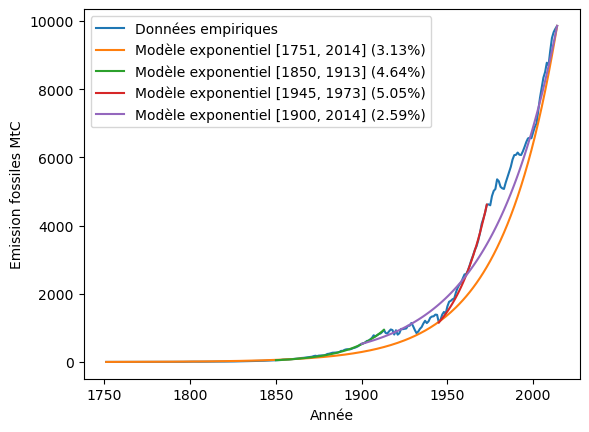

In [13]:
# Graphe des données de la base de données
plt.plot(X, Y, label='Données empiriques')      # afficher les données brutes
                                                # sous forme de graphe
plt.xlabel('Année')                             # nommer l'axe des x
plt.ylabel('Émission fossiles MtC')             # nommer l'axe des y

# Graphes des donnés issues du modèle
# Pour chaque période
for debut, fin in periodes:
    X_, Y_ = donneesPeriode(X, Y, debut, fin)   # récupérer les valeurs de la
                                                # base de données sur cette
                                                # période
    Y_modele = modeles[(debut, fin)]            # récupérer le ordonnées
                                                # calculées sur base du modèle
    croissance = croissances[((debut, fin))]    # récupérer le taux de
                                                # croissance caclulé par
                                                # ajustement de courbes

    # ajouter la courbe à la figure
    plt.plot(X_, Y_modele,
             label='Modèle exponentiel [{debut}, {fin}] ({croissance:.2f}%)'
                    .format(debut=debut, fin=fin, croissance=croissance))

plt.legend()                                    # afficher la légende

Quelle a été la quantité totale d'émissions fossiles durant la période couverte
par le jeu de données selon le modèle et comment se compare-t’elle aux valeurs
obtenues sur base des données du jeu de données?

In [14]:
debut = X[0]                        # date de première mesure
fin = X[len(X)-1]                   # date de dernière mesure
total = sum(Y)                      # total des émissions

Y_modele = modeles[(debut, fin)]    # récupérer les données du modèle
total_modele = sum(Y_modele)        # total des émissions selon le modèle exponentiel

# afficher le total
print ("L'humanité a émis {total} MtC entre {debut} et {fin} et le modèle en calcule {total_modele} MtC."
        .format(debut=debut, fin=fin, total=total, total_modele=total_modele) ) 


L'humanité a émis 402068 MtC entre 1751 et 2014 et le modèle en calcule 324953.9034557014 MtC.


L'avantage des modèles est qu'ils permettent de cacher une partie de la
complexité des phénomènes réels et nous permettent d'estimer certaines
quantités. Dans la suite, nous allons évaluer le temps de doublement des
émissions fossiles. Si le temps de doublement est de $n$ années, cela veut dire
que toutes les $n$ années le taux d'émission est doublé.

Pour calculer le temps de doublement, revenons au modèle exponentiel que nous
avons défini par _y(n) = C^n \* y(0)_.

Ce qui nous intéresse ici c'est de trouver la valeur de _n_ telle que
_y(n) = 2 \* y(0)_

Nous pouvons donc raisonner sur la relation _2 \* y(0) = C^n \* y(0)_ que l'on
peut réduire à _2 = C^n_ afin de trouver _n_. Le problème ici est que _n_ est un
exposant et nous ne disposons pas encore de l'outil idéal pour résoudre ce
problème. Toutefois cet outil existe et s'appelle le _logarithme_, qui n'est
rien d'autre que l'inverse de la fonction exponentielle. Nous n'entrerons pas
dans les détails ici mais une des propriété du logarithme est que _log(C^n)_ est
équivalent à _n \* log(C)_ pour
_C > 0_ et _n > 0_.

Nous pouvons donc ré-écrire notre formule

_2 = C^n_

en

_log(2) = n \* log(C)_.

Nous voyons que le temps de doublement d'une exponentielle dépend uniquement de
son facteur de croissance. Nous pouvons dès lors écrire la fonction
`tempsDoublement(croissance)` qui retourne le temps de doublement de la fonction
exponentielle caractérisée par le facteur de croissance `croissance`.

__note 1 :__ En python le calcul du logarithme du nombre _n_ se fait grâce à
l'expression `log(n)`.

__note 2 :__ il est évident qu'en réalité on peut utiliser un _y(x)_ arbitraire à 
la place de _y(0)_!

__note 3 :__ que se passe-t’il quand _ 0 < croissance < 1_?

In [15]:
def tempsDoublement(croissance):
    """
    Parameters
    ----------
    croissance: float
        le taux de croissance exprimé en pourcents
    
    Returns
    -------
    float
        le temps de doublement
    """
    C = 1.0 + (croissance / 100.0)  # facteur de croissance sur base du taux de
                                    # croissance annuel

    temps = log(2) / log (C)        # calcul du temps de doublement

    return temps                    # retourner le temps de doublement

Nous avons déjà calculé le taux de croissance annuel en pourcent pour chaque
période et stocké cette information dans le dictionnaire `croissances`. Pour
calculer le temps de doublement sur ces périodes nous allons donc itérer sur
tout le dictionnaire `croissance` et enregistrer ces données dans un
dictionnaire nommé `doublements` qui utilise la période comme clé et la durée de
doublement comme valeur, exprimée en années entières.

Créons le dictionnaire `doublements` qui stockera les périodes de doublement
calculées par le modèle exponentiel pour toutes les périodes.

In [16]:
doublements = dict()    # temps de doublement calculés pour chaque période
                        #   clé: période sous la forme (debut, fin)
                        #   valeur: temps de doublement, en années entières

In [17]:
# Graphes des donnés issues du modèle
# Pour chaque période
for (periode, croissance) in croissances.items():
    temps = tempsDoublement(croissance)     # calculer le temps de doublement
    temps = ceil (temps)                    # arrondir le temps de doublement à
                                            # l'année entière supérieure la plus
                                            # proche

    doublements[periode] = temps             # mémorier le temps de doublement

    # afficher le temps de doublement
    print ("Temps de doublement pour la période [{debut}, {fin}]: {temps} années"
          .format(debut=periode[0], fin=periode[1], temps = temps))

Temps de doublement pour la période [1751, 2014]: 23 années
Temps de doublement pour la période [1850, 1913]: 16 années
Temps de doublement pour la période [1945, 1973]: 15 années
Temps de doublement pour la période [1900, 2014]: 28 années


> **Commentez les temps de doublements obtenus.**

## Validation des résultats

Un modèle étant une approximation de la réalité afin de favoriser un
raisonnement particulier selon certaines hypothèses, il est essentiel de le
valider et de vérifier s'il est en adéquation avec les hypothèses initialement
posées. En faisant de la sorte, nous sommes en mesure de connaître ses
limitations et de ne pas lui faire dire plus que ce qu'il peut dire.

Nous allons ici nous contenter d'une validation relativement simple (mais non
simpliste) de notre modèle en comparant les valeurs de doublement obtenues avec
les valeurs observées dans la base de données elle-même.

Pour cela calculons le rapport entre la valeur de la dernière année qui
apparait dans la base de données et l'année du début de la période de doublement.
En théorie le rapport devrait valoir 2.

Créons le dictionnaire `rapports` qui stockera le rapport ainsi mesuré sur
les données de la base de données.

In [18]:
rapports = dict()   # rapport mesuré pour chaque période
                    #   clé: période sous la forme (debut, fin)
                    #   valeur: rapport

Pour chaque période, calculons le rapport et enregistrons-le dans `rapports`.

In [19]:
# Pour chaque période
for debut, fin in periodes:
    fin_periode_double = fin        # fin de la dernière période de doublement
    debut_periode_double = fin - doublements[(debut, fin)]  # début de la
                                                            # dernière période
                                                            # de doublement

    # obtention des données sur la dernière période de doublement
    X_periode_double, Y_period_double = donneesPeriode(X, Y, debut_periode_double, fin_periode_double)

    y_debut_periode = Y_period_double[0]                        # emissions au
                                                                # début de la
                                                                # période
    y_fin_periode = Y_period_double[len(Y_period_double) - 1]   # émissions à la
                                                                # fin de la
                                                                # période

    rapport = y_fin_periode / y_debut_periode           # calcule du rapport

    rapports[(debut, fin)] = rapport                    # mémoriser le rapport

Effectuons la même opération mais cette fois-ci sur les valeurs calculées avec
le modèle exponentiel plutôt que les valeurs lues dans la base de données.

Créons le dictionnaire `rapports_modele` qui stockera le rapport ainsi calculé
avec le modèle exponentiel.

In [20]:
rapports_modele = dict()    # rapport calculé avec le modèle exponentiel pour
                            # chaque période
                            #   clé: période sous la forme (debut, fin)
                            #   valeur: rapport

Pour chaque période, calculons le rapport et enregistrons-le dans
`rapports_modele`.

In [21]:
# Pour chaque période
for debut, fin in periodes:
    fin_periode_double = fin        # fin de la dernière période de doublement
    debut_periode_double = fin - doublements[(debut, fin)]  # début de la
                                                            # dernière période
                                                            # de doublement
    croissance = croissances[(debut, fin)]  # récupérer le taux de croissance
                                            # sur la période

    n_debut_periode_double = debut_periode_double - debut   # nombre d'années
                                                            # écoulées entre le
                                                            # début des mesures
                                                            # et le début de la
                                                            # dernière période
                                                            # de doublement
    n_fin_periode_double = fin_periode_double - debut   # nombre d'années
                                                        # écoulées entre le
                                                        # début des mesures et
                                                        # la fin de la dernière
                                                        # période de doublement

    y_debut_periode_modele = modeleExponentiel(croissance, Y[0], n_debut_periode_double) # calculer la valeur de l'expontentielle au début de la dernière période de doublement
    y_fin_periode_modele = modeleExponentiel(croissance, Y[0], n_fin_periode_double)     # calculer la valeur de l'expontentielle à la fin de la dernière période de doublement

    rapport = y_fin_periode_modele / y_debut_periode_modele # calcule du rapport
    rapports_modele[(debut, fin)] = rapport                 # mémoriser le rapport

Pour chaque période affichez les rapports tels que mesurés avec les données de
la base de données et ceux obtenus sur base du modèle exponentiel.

> **Commentez les résultats, particulièrement pourquoi le rapport ne vaut pas 2,
> même lorsque l'on utilise le modèle exponentiel.**

In [22]:
# pour chaque période
for debut, fin in periodes:
    rapport = rapports[(debut, fin)]                 # obtenir le rapport mesuré
    rapport_modele = rapports_modele[(debut, fin)]   # obtenir le rapport calculé

    # afficher le rapport entre les émissions de la période 
    print ('rapports pour la période [{}, {}]: {} vs {}'.
            format(debut, fin, rapport, rapport_modele))

rapports pour la période [1751, 2014]: 1.6045262129599478 vs 2.030157395459503
rapports pour la période [1850, 1913]: 2.143181818181818 vs 2.067561909701151
rapports pour la période [1945, 1973]: 1.9802575107296136 vs 2.09519662684903
rapports pour la période [1900, 2014]: 1.7651800107469102 vs 2.046330160566663


# Pour aller plus loin


## Ne pas suivre l'intuition
Nous construisons notre intuition sur base des habitudes que nous avons. Par
exemple, nous avons l'habitude de faire progresser les valeurs sur les axes des
graphiques suivant une échelle linéaire qui a un effet sur la forme visuelle que
les courbes prennent. À la place de suivre une échelle linéaire pour l'axe
des ordonnées, prenons une échelle logarithmique pour représenter les données
brutes d'émissions fossiles.

Est-ce que votre intuition vous joue des tours?

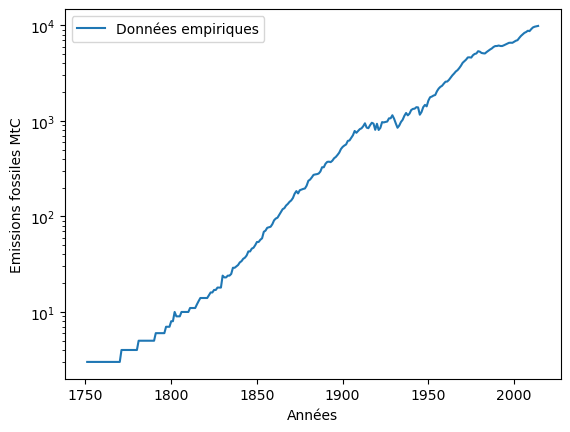

In [23]:
plt.plot(X, Y, label='Données empiriques')  # tracer la courbe
plt.xlabel('Années')                        # nommer l'axe des x
plt.ylabel('Émissions fossiles MtC')        # nommer l'axe des y
plt.legend()                                # afficher la légende

plt.yscale('log')                           # afficher l'axe des ordonnées en
                                            # échelle logarithmique

## Données cumulées
 Soit la suite $V(n)$ constituée des émissions cumulées entre l’année 1751 et l'année $n$ :
 $$ V(n)= \sum_{k=0}^n Y(k)$$

 Le modèle exponentiel possède une propriété remarquable : cette suite $V(n)$
 suit à partir d’un certain rang une progression géométrique de même raison que
 la suite $Y(n)$.
 
 On peut ajuster un modèle exponentiel à partir de l’année 1900 par exemple, un
 choix qui garantit que notre approximation est valide.

Temps de doublement pour la période [1900, 2014]: 23 années


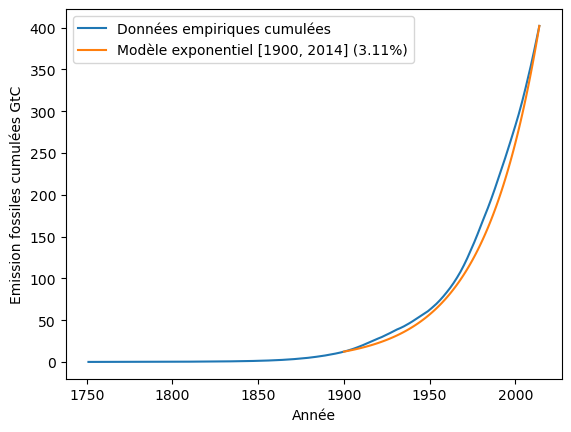

In [24]:
V = [sum(Y[0:n+1]) for n in range(len(Y))]  # calculer le cumul d'émissions
                                            # brutes
V = list(map(lambda v: v/1000, V))          # convertir les données en GtC

debut = 1900
fin = X[len(X)-1]

# calculer les parametres du modèle sur l'intervalle de temps
X_, Y_, V_modele, taux = parametresModeleExponentielPeriode(X, V, debut, fin)

# Graphe des données de la base de données
plt.plot(X, V, label='Données empiriques cumulées') # afficher les données
                                                    # brutes cumulées
                                                    # sous forme de graphe
plt.xlabel('Année')                                 # nommer l'axe des x
plt.ylabel('Émission fossiles cumulées GtC')        # nommer l'axe des y

# ajouter la courbe à la figure
plt.plot(X_, V_modele,
            label='Modèle exponentiel [{debut}, {fin}] ({croissance:.2f}%)'
                .format(debut=debut, fin=fin, croissance=taux))

plt.legend()                    # afficher la légende


temps = tempsDoublement(taux)   # calculer le temps de doublement
temps = ceil (temps)            # arrondir le temps de doublement à
                                # l'année entière supérieure la plus
                                # proche

# afficher le temps de doublement
print ("Temps de doublement pour la période [{debut}, {fin}]: {temps} années"
        .format(debut=periode[0], fin=periode[1], temps = temps))

Commentez les résultats et comparez-les avec les résultats obtenus sur les
données brutes non cumulées.

## Croisement d'information
Trouvez d'autres sources de données publiques et comparez les résultats
obtenus. Si les données que vous trouvez sont plus récentes, émettez des
prévisions d'émissions sur bases de nos données et comparez les aux observations
plus récentes.

# References
[1] Boden, T.A., G. Marland, and R.J. Andres. 2017. Global, Regional, and
    National Fossil-Fuel CO2 Emissions. Carbon Dioxide Information Analysis
    Center, Oak Ridge National Laboratory, U.S. Department of Energy, Oak Ridge,
    Tenn., U.S.A. doi 10.3334/CDIAC/00001_V2017.

[2] Louis, F. 2021. Daniel , peux-tu nous parler des séries temporelles ?,
    DataScientest, https://datascientest.com/series-temporelles.

[3] Chevillard, S. 2022. Cours enjeux environnementaux Bilan carbone.
    http://www-sop.inria.fr/members/Sylvain.Chevillard/enseignement_sommaire_fr.php.

[4] Matplotlib: Visualization with Python. 2022. https://matplotlib.org/.

[5] Pyplot function overview. 2022.
    https://matplotlib.org/stable/api/pyplot_summary.html.

[6] Comment travailler avec le dictionnaire Python - Tutoriel avec des exemples
    de code. 2022.
    https://fr.myservername.com/how-work-with-python-dictionary-tutorial-with-code-examples.